# Идентификация пользователей по посещенным веб-страницам.
В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.

Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

### Все реализованные для проекта функии размещены в модуле funcs.py. Импортируем их.

In [5]:
from funcs import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import importlib
importlib.reload(funcs2)

In [6]:
import funcs
funcs2.__doc__

'Модуль со всеми необходимыми функциями: glob(path), convert_to_csr(X), site_freqs(path_to_csv_files), prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10), plot_validation_curves(param_values, grid_cv_results_), save_data(num_users, window_size, session_length), plot_validation_curves(param_values, grid_cv_results_), plot_learning_curve(val_train, val_test, train_sizes, xlabel=\'Training Set Size\', ylabel=\'score\'), write_to_submission_file(predicted_labels, out_file, target=\'target\', index_label="session_id"), add_time_features(df, X_sparse), add_day_feature(df, X_sparse)'

In [7]:
PATH_TO_DATA = r'C:\Users\nspap\_jupiter_work'

## Часть 1. Подготовка обучающей выборки и построение признаков.

Посмотрим на исходные данные:

In [8]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

*timestamp, посещенный веб-сайт*

В начале напишем функцию site_freqs(path_to_csv_files), которая принимая путь к папке, считывает все файлы, считает частоты посещения для каждого сайта и возвращает словарь сайт: частота посещения. Будем использовать параллельно 2 выборки: по 10 пользователям и по 150. Для 10 пользователей будем писать и отлаживать код, для 150 – будет рабочая версия.

Применим её для выборок из 10 и 150 пользователей и сохраним результаты в файл.

In [9]:
site_freq_10users = site_freqs(os.path.join(PATH_TO_DATA, '10users'))
site_freq_150users = site_freqs(os.path.join(PATH_TO_DATA, '150users'))

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

Теперь реализуем основную функцию для предобработки данных и добавления признаков:

prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10)

Функция будет принимать на вход путь к исходным данным, путь к словарю частот, массив с названиями созданных признаков, а так же длину сессии и ширину окна, дефолтные значения которых будут=10, а возвращать датафрейм, строками в котором будут сессии, а столбцами признаки. 

Создадим в неё новые признаки: продолжительность сессии, количество уникальных сайтов, час начала сессии, день недели.

Продемонстрируем её работу на примере:

In [11]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [12]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,134,3,134,134,3,134,203,134,33,5,8,4,31
1,425,193,687,254,134,31,394,3841,218,55,284,10,8,4,31
2,55,3,55,55,5,293,425,340,908,55,258,7,8,4,31
3,473,4015,473,55,55,55,55,980,201,123,30,6,8,4,31
4,348,55,5,3837,258,212,3937,2157,676,2157,6,9,8,4,31


Первые 10 столбцов это индексы сайтов в сессии. Затем идут: продолжительность сессии, количество уникальных сайтов, час начала сессии, день недели. Последний столбец - "ответы", те индекс пользователя, чья это сессия.

Применим эту функцию к данным на 150 пользователей и сохраним результаты в файлы.

In [13]:
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'train_data_10users.pkl'), 'wb') as train_data_10users_pkl:
    pickle.dump(train_data_10users, train_data_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'train_data_150users'), 'wb') as train_data_150users_pkl:
    pickle.dump(train_data_150users, train_data_150users_pkl, protocol=2)

Т.к. признаки site1...site10 не имеют особого смысла в задачи классификации, реализуем функцию convert_to_csr(X), принимающую на вход матрицу и преобразующую её в разреженный вид: в ней строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки  $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$

Продемонстрируем работу на примере:

In [15]:
sites = ['site' + str(i) for i in range(1,11)] + ['target']
train_df = train_data_10users[sites]
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
0,192,577,134,3,134,134,3,134,203,134,31
1,425,193,687,254,134,31,394,3841,218,55,31
2,55,3,55,55,5,293,425,340,908,55,31
3,473,4015,473,55,55,55,55,980,201,123,31
4,348,55,5,3837,258,212,3937,2157,676,2157,31


In [16]:
X_10users, y_10users = train_df.iloc[:, :-1].values, \
                       train_df.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values
X_sparse_10users = convert_to_csr(X_10users)
X_sparse_150users = convert_to_csr(X_150users)
X_sparse_10users.todense()

matrix([[0, 0, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

Сохраним матрицы в файлы.

In [17]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)

## Часть 2. Первичный анализ данных, проверка гипотез

In [18]:
train_df['target'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: target, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов. Построим гистограмму и Q-Q plot этого распределения.

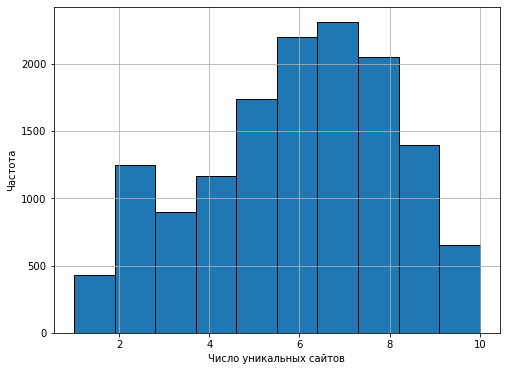

In [19]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0]
                    for i in range(train_df.shape[0])]
pd.Series(num_unique_sites).value_counts()
pd.Series(num_unique_sites).hist(edgecolor='k', figsize=(8, 6)).set(xlabel='Число уникальных сайтов', ylabel='Частота')
plt.show()

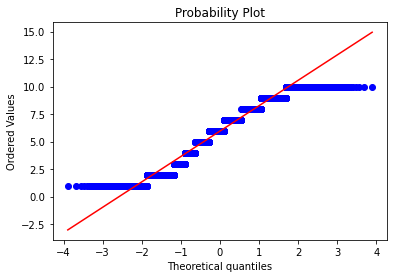

In [20]:
stats.probplot(num_unique_sites, dist="norm", plot=plt)
plt.show()

In [21]:
print('Проверка на нормальность с помощью критерия Шапиро-Уилка: p-value =', stats.shapiro(num_unique_sites)[1])

Проверка на нормальность с помощью критерия Шапиро-Уилка: p-value = 0.0


Величина распределена не нормально.

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

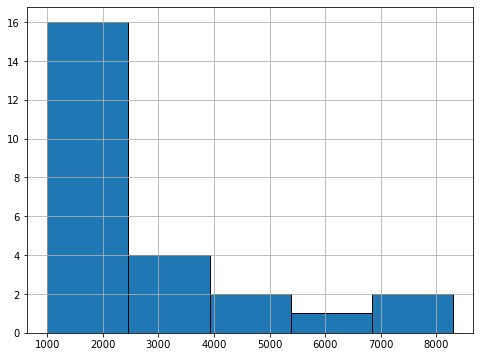

In [22]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as f_in:
    site_freqs = pd.DataFrame(pickle.load(f_in), index=['id', 'freq'])
site_freqs.loc['freq', :][site_freqs.loc['freq', :] > 1000].hist(edgecolor='k', figsize=(8, 6), bins=5)
plt.show()

## Часть 3. Визуальный анализ данных

In [23]:
id_name_dict = {
    128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
    33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Построим гистограмму распределения длины сессии в секундах (session_timespan)**

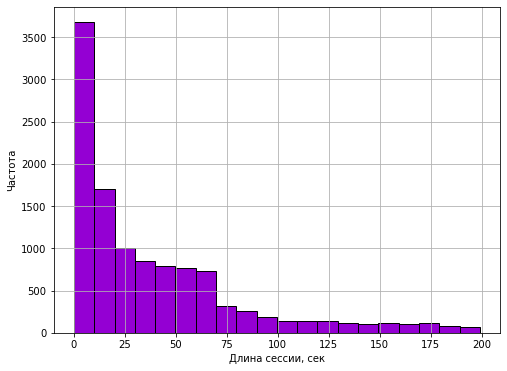

In [24]:
session_timespan_200 = train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200]
session_timespan_200.hist(color='darkviolet', edgecolor='k', figsize=(8, 6), bins=20) \
            .set(xlabel='Длина сессии, сек', ylabel='Частота')
plt.show()

**2. Построим гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*).**

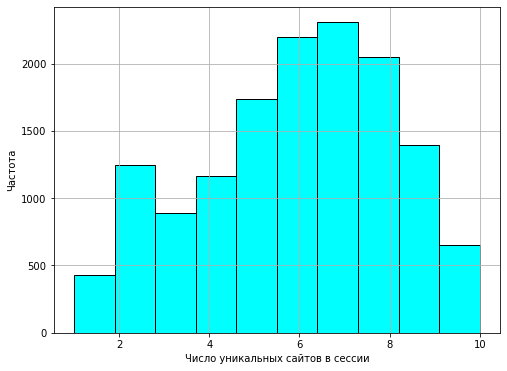

In [25]:
train_data_10users['#unique_sites'].hist(color='aqua', edgecolor='k', figsize=(8, 6)) \
            .set(xlabel='Число уникальных сайтов в сессии', ylabel='Частота')
plt.show()

**3. Построим гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности.**

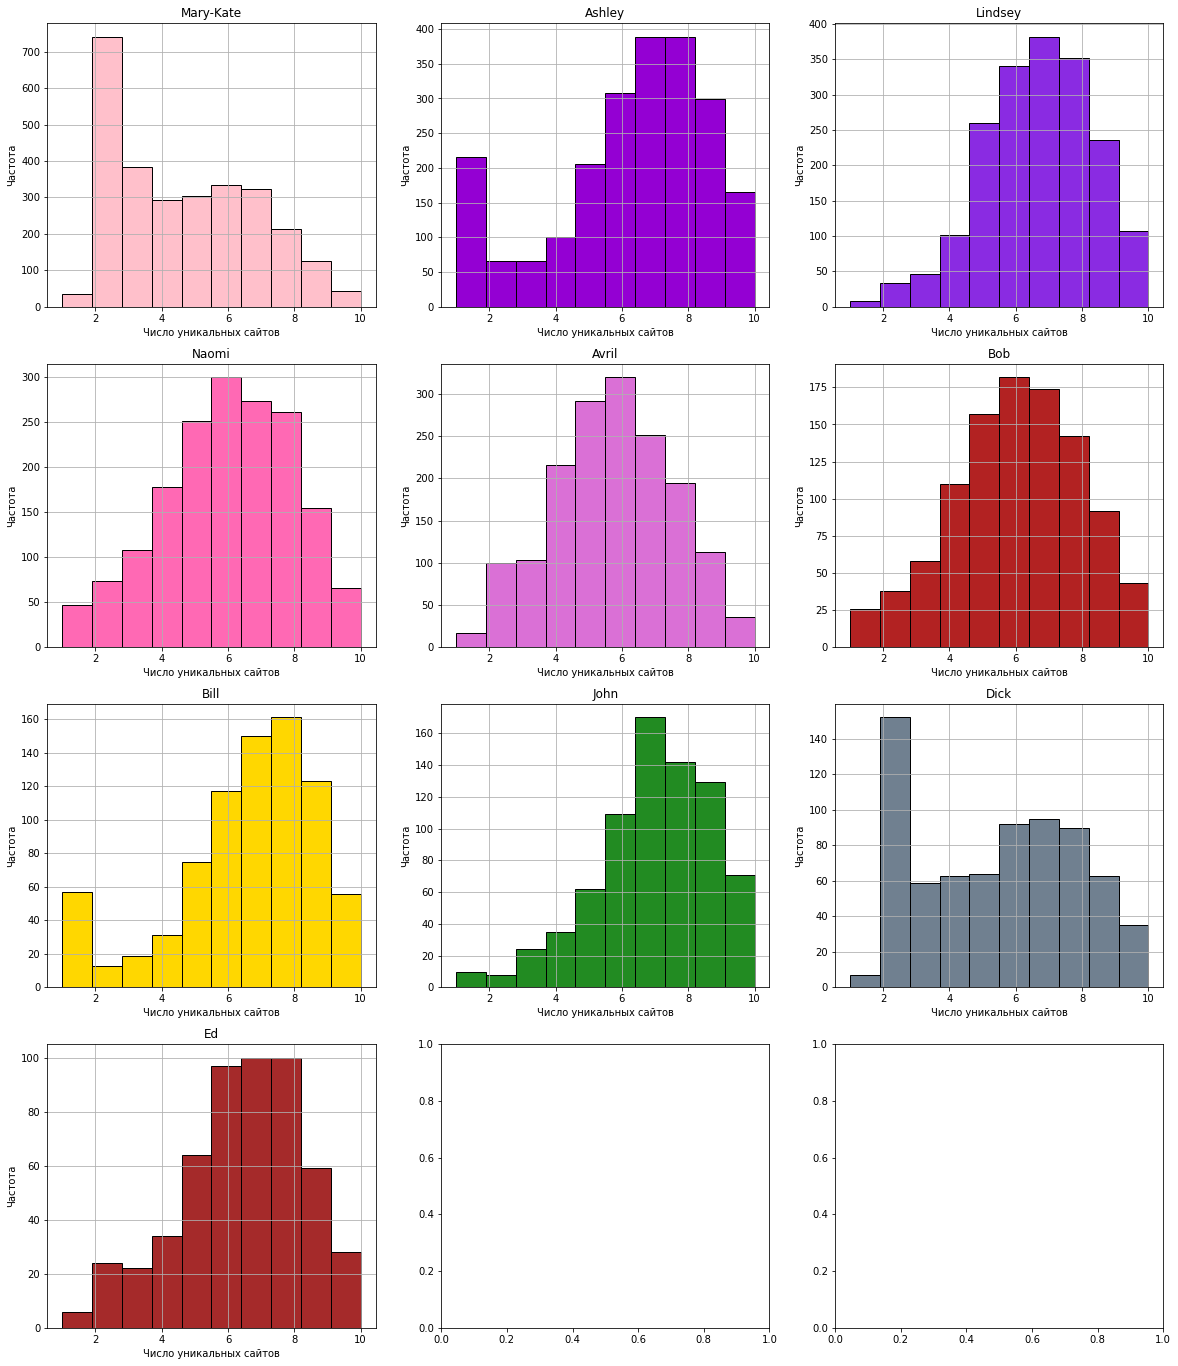

In [26]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['#unique_sites'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=10).set(
        xlabel='Число уникальных сайтов', ylabel='Частота', label=name)
    pos += 1

**4. Построим гистограмму распределения часа начала сессии (*start_hour*).**

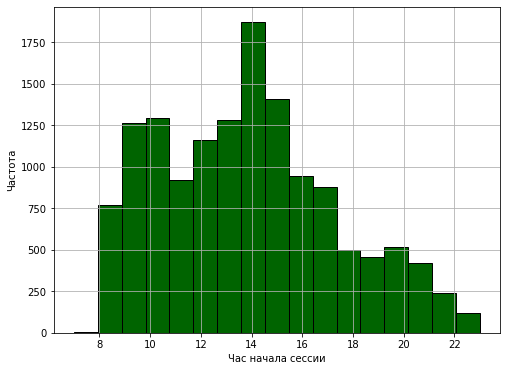

In [27]:
train_data_10users['start_hour'].hist(color='darkgreen', edgecolor='k', figsize=(8, 6), bins=17).set(
    xlabel='Час начала сессии', ylabel='Частота')
plt.show()

**5. Построим гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности.**

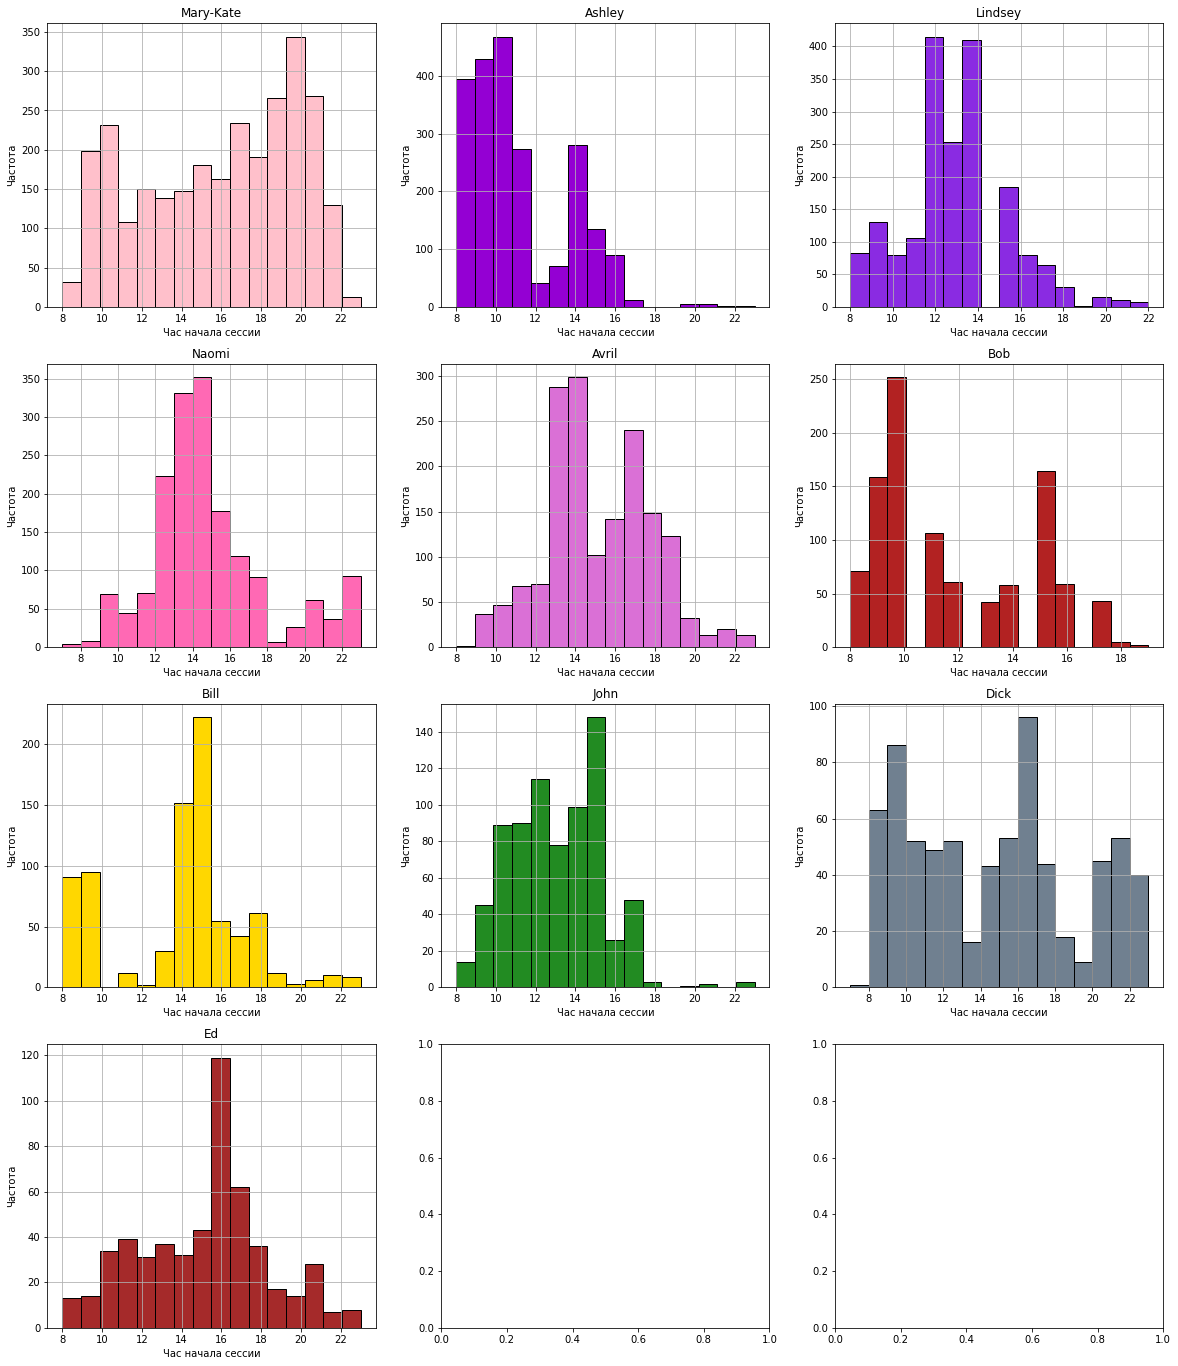

In [28]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['start_hour'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=16).set(
        xlabel='Час начала сессии', ylabel='Частота', label=name)
    pos += 1

**6. Построим гистограмму распределения дня недели, в который началась сессия (*day_of_week*).**

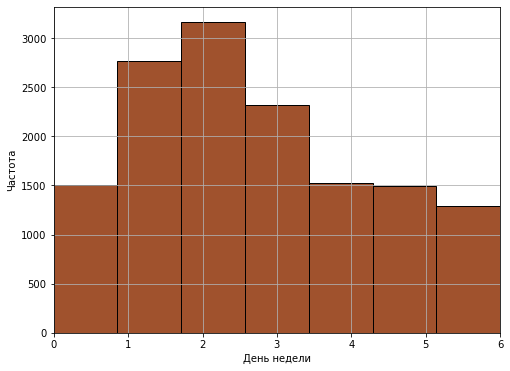

In [29]:
train_data_10users['day_of_week'].hist(color='sienna', edgecolor='k', figsize=(8, 6), bins=7).set(
    xlabel='День недели', ylabel='Частота', xlim=[0, 6])
plt.show()

**7. Построим гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности.**

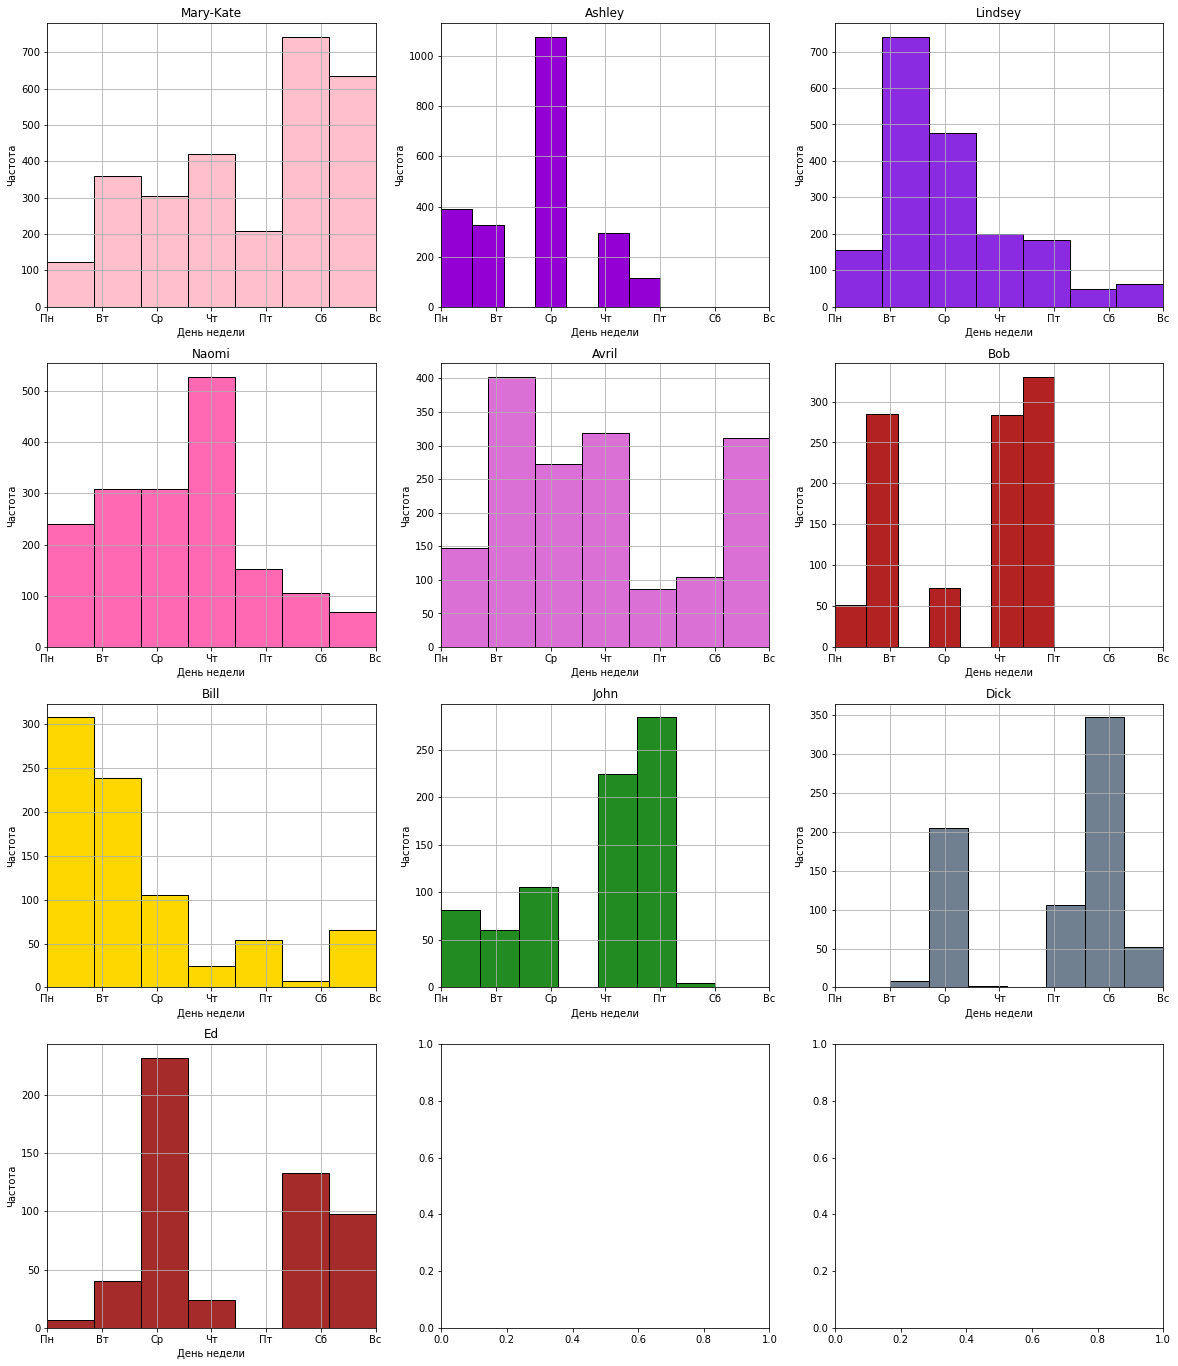

In [30]:
days_of_week = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['day_of_week'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=7).set(
        xlabel='День недели', xticklabels=days_of_week, ylabel='Частота', label=name, xlim=[0, 6])
    pos += 1

In [31]:
# количество сессий у разных пользователей
train_data_10users['target'].value_counts()

Mary-Kate    2796
Ashley       2204
Lindsey      1868
Naomi        1712
Avril        1643
Bob          1022
Bill          802
John          760
Dick          720
Ed            534
Name: target, dtype: int64

Хоть и есть схожие паттерны поведения (особенно в количестве уникальных сайтов), но в целом пользователи довольно сильно отличаются.
* Mary-Kate - она в принципе гораздо чаще остальных заходит на сайты. При этом большинство сессий имеет 2 уникальных сайта. В этом её поведение схоже с Dick'ом, правда тот гораздо реже заходит в интернет. Её активность более-менее равномерно распределена в течении дня и заметно увеличивается к вечеру. Похоже и с днями недели - маленькая активность в понедельние, средняя в течении недели и высокая на выходных.
* Ashley напротив, не заходит в сеть в выходные и по вечерам, основная активность приходится на утро и будние дни. В сессиях или один уникальный сайт, или довольно много разных сайтов.
* Lindsey - основная активность приходится на вторник с постепенным уменьшением к выходным. Чаще всего это середина дня, очень низкая активность вечером. В большинстве сессий много (6-8) уникальных сайтов.
* Naomi довольно сильно похожа на Линдси, главные отличия - гораздо ниже активность рано утром, и основной день не вторник, а четверг.
* Avril - количество уникальных сайтов имеет практически нормальное распределение со средним = 6. Основное время в сети - 15 и 18 часов со вторника по четверг + воскресение. 
* Bob - как и все последующие пользователи меньше , чем предыдущие пользователи сидит в интернете, но когда заходит, посещает сразу много разных сайтов. Пик активности - вт, чт, пц утро и 15 часов.
* Bill - так же, как и Боб, посещает много разных сайтов. Основная активность 9 утра и 15 часов дня в пн и вт. 
* John - основные дни чт и пт, 12 и 15 дня, в среднем 7 уник сайтов.
* Dick и Ed - имеют схожее поведение - пики активности на среду и выходные, 16 часов дня. А вот распределение уникальных сайтов отличается.

**Определим топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [32]:
top10 = site_freqs.loc['freq', :].sort_values(ascending=False)[:10]
top10_freqs = top10.tolist()
top10_sites = top10.index.tolist()
top10

s.youtube.com                           8300
www.google.fr                           7813
www.google.com                          5441
mail.google.com                         4158
www.facebook.com                        4141
apis.google.com                         3758
r3---sn-gxo5uxg-jqbe.googlevideo.com    3244
r1---sn-gxo5uxg-jqbe.googlevideo.com    3094
plus.google.com                         2630
accounts.google.com                     2089
Name: freq, dtype: int64

**9. Нарисуем *seaborn barplot*, показывающий частоты посещений топ-10 сайтов.**

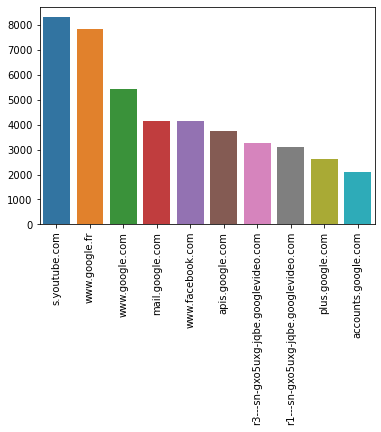

In [33]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90)
plt.show()

## Часть 4. Сравнение алгоритмов классификации

Будем работат с разреженной матрицей, построенной на данных о 10 пользователях.

In [34]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [36]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.**

In [37]:
logit = LogisticRegression(random_state=17)
logit_cv_score = cross_val_score(logit, X_train, y_train, cv=skf)
logit_cv_score.mean()

0.7606189739891912

In [38]:
logit.fit(X_train, y_train)
logit_acc = accuracy_score(logit.predict(X_valid), y_valid)
logit_acc

0.7767243422611994

**С помощью `LogisticRegressionCV` подберём параметр `C` для `LogisticRegression`  в  диапазоне: 10 значений от 1e-4 до 1e2**

In [39]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(
    Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

In [40]:
accuracy_score(logit_grid_searcher1.predict(X_valid), y_valid)

0.7750651813225883

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [41]:
logit_mean_cv_scores1 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher1.scores_.items()]).mean(axis=0)
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76122864, 0.75787588, 0.75025516, 0.74039964])

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [42]:
np.max(logit_mean_cv_scores1), logit_c_values1[np.argmax(logit_mean_cv_scores1)]

(0.7612286371644574, 1.0)

График зависимости доли правильных ответов на кросс-валидации от `C`.

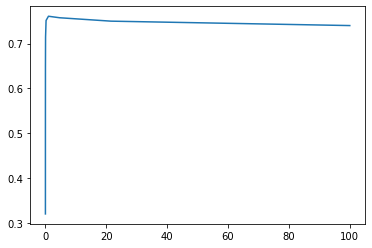

In [43]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)

**Теперь для значения параметра `C` в диапазоне `np.linspace`(0.1, 7, 20).**

In [44]:
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(
    Cs=logit_c_values2, multi_class='multinomial', random_state=17, cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [45]:
logit_mean_cv_scores2 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher2.scores_.items()]).mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75919655, 0.76092382, 0.7608222 , 0.76122858,
       0.76133029, 0.76000937, 0.75929815, 0.75970453, 0.75909496,
       0.75919661, 0.75858698, 0.75767262, 0.75736787, 0.75706302,
       0.75635177, 0.75553904, 0.75513262, 0.7543198 , 0.7533037 ])

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [46]:
np.max(logit_mean_cv_scores2), logit_c_values2[np.argmax(logit_mean_cv_scores2)]

(0.761330294154816, 1.9157894736842107)

График зависимости доли правильных ответов на кросс-валидации от `C`.

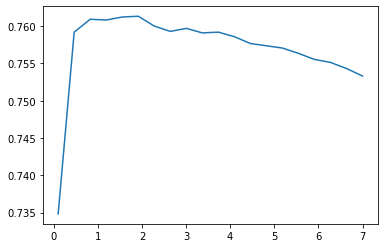

In [47]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Доля правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [48]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7788575491822707

**Обучим линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.**

In [49]:
svm = LinearSVC(C=1, random_state=17).fit(X_valid, y_valid)
svm_cv_score = cross_val_score(svm, X_train, y_train, cv=skf)
svm_cv_score.mean()

0.7509671352428245

In [50]:
svm_cv_acc = accuracy_score(y_valid, svm.fit(X_train, y_train).predict(X_valid))
svm_cv_acc

0.7769613652524295

**С помощью `GridSearchCV` подберём параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4.**

In [51]:
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])})

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [52]:
svm_grid_searcher1.best_params_

{'C': 4444.4445000000005}

In [53]:
svm_grid_searcher1.best_score_

0.6952843773612952

**С помощью `GridSearchCV` подберём параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений**

График зависимости доли правильных ответов на кросс-валидации от `C`.

In [54]:
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [55]:
print(svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_)

{'C': 0.10434482758620689} 0.7701686093803548


Доля правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [56]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.7807537331121118

## Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*).**

**Для этого еализуем функцию `model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3)`**

Её документация:

In [57]:
print(model_assessment.__doc__)


    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) loaded from path_to_X_pickle
    and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.

    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split

    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    


Пример работы функции:

In [58]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s10_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s10_w10.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Применим функцию *model_assessment* для лучшего алгоритма - `svm_grid_searcher2.best_estimator_` и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведем в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*.

In [59]:
estimator = svm_grid_searcher2.best_estimator_
results = []
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(
            PATH_TO_DATA, 'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(
            PATH_TO_DATA, 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv, acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print('window_size=', window_size, 'session_length=', session_length)
        print('cv_score=', cv, 'accuracy_score=', acc)
        results.append([window_size, session_length, cv, acc])

window_size= 10 session_length= 15
cv_score= 0.8243252292702751 accuracy_score= 0.8404835269021095
window_size= 10 session_length= 10
cv_score= 0.7670206386611259 accuracy_score= 0.7807537331121118
window_size= 7 session_length= 15
cv_score= 0.8495024256089474 accuracy_score= 0.8543222166915547
window_size= 7 session_length= 10
cv_score= 0.7983645917156946 accuracy_score= 0.8073668491786958
window_size= 7 session_length= 7
cv_score= 0.754765400423003 accuracy_score= 0.7617388418782147
window_size= 5 session_length= 15
cv_score= 0.8670355547005402 accuracy_score= 0.8752963489805595
window_size= 5 session_length= 10
cv_score= 0.8177520250854086 accuracy_score= 0.8245614035087719
window_size= 5 session_length= 7
cv_score= 0.772939529035208 accuracy_score= 0.7853247984826932
window_size= 5 session_length= 5
cv_score= 0.7254849424351582 accuracy_score= 0.7362494073020389


In [60]:
results

[[10, 15, 0.8243252292702751, 0.8404835269021095],
 [10, 10, 0.7670206386611259, 0.7807537331121118],
 [7, 15, 0.8495024256089474, 0.8543222166915547],
 [7, 10, 0.7983645917156946, 0.8073668491786958],
 [7, 7, 0.754765400423003, 0.7617388418782147],
 [5, 15, 0.8670355547005402, 0.8752963489805595],
 [5, 10, 0.8177520250854086, 0.8245614035087719],
 [5, 7, 0.772939529035208, 0.7853247984826932],
 [5, 5, 0.7254849424351582, 0.7362494073020389]]

Лучшая модель с параметрами: window_size= 5 session_length= 15

**Сравним для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10)**

In [61]:
estimator = svm_grid_searcher2.best_estimator_
results = []
for window_size, session_length in [(5, 5), (7, 7), (10, 10)]:
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(
            PATH_TO_DATA, 'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(
            PATH_TO_DATA, 'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv, acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print('session_length=', session_length, 'window_size=', window_size)
        print('cv_score=', cv, 'accuracy_score=', acc)
        results.append([session_length, window_size, cv, acc])

session_length= 5 window_size= 5
cv_score= 0.4083611011164474 accuracy_score= 0.42171606560568453
session_length= 7 window_size= 7
cv_score= 0.4366487102001489 accuracy_score= 0.45295840855673264
session_length= 10 window_size= 10
cv_score= 0.46307591254574465 accuracy_score= 0.4836276942538802


Точность классификации на 150 пользователей заметно падает. Лучшая точность при длине и сессии и окна = 10.

## Идентификация  конкретного пользователя и кривые обучения

**Будем использовать объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [62]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучим `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации). Будем решать 150 задач "Один-против-Всех"**

In [63]:
logit_cv_150users = LogisticRegressionCV(
    Cs=[logit_grid_searcher2.Cs_[10]], random_state=17, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

LogisticRegressionCV(Cs=[3.7315789473684213],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', random_state=17)

**Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [64]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9960067978271975
User 13, CV score: 0.9965385297092156
User 15, CV score: 0.9952873958691731
User 16, CV score: 0.9916486816177161
User 28, CV score: 0.9900639120869954
User 31, CV score: 0.9942447843358044
User 33, CV score: 0.9935149562624462
User 39, CV score: 0.9855598302628423
User 46, CV score: 0.9980190380865993
User 49, CV score: 0.9951727086005026
User 50, CV score: 0.9942030798744695
User 53, CV score: 0.9937756091457883
User 65, CV score: 0.9967470520158894
User 66, CV score: 0.994724385641154
User 82, CV score: 0.996225746249205
User 85, CV score: 0.9962570245952062
User 89, CV score: 0.9905643656230126
User 92, CV score: 0.9949329079478276
User 100, CV score: 0.9943386193738076
User 102, CV score: 0.991679959963717
User 103, CV score: 0.9805344426720048
User 105, CV score: 0.9969347220918957
User 106, CV score: 0.9948286467944909
User 118, CV score: 0.9909918363516937
User 119, CV score: 0.9965906602858841
User 120, CV score: 0.9942239321051369
User 126

**Результаты кажутся впечатляющими, но возможно, из-за дисбаланса классов высокую долю правильных ответов можно получить константным прогнозом. Посчитаем для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [65]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(
        logit_cv_150users.scores_[user_id].mean() - (class_distr.sum() - class_distr[user_id]) / class_distr.sum())

Доля пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного:

In [66]:
num_better_than_default = (np.array(list(acc_diff_vs_constant)) > 0).sum()
print(round(num_better_than_default/150.0, 3))

0.813


**Построим кривые обучения для конкретного пользователя, допустим, для 128-го.**

In [67]:
y_binary = (y_train_150 == 128).astype('int')

In [68]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [69]:
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary, train_sizes=train_sizes, cv=skf)

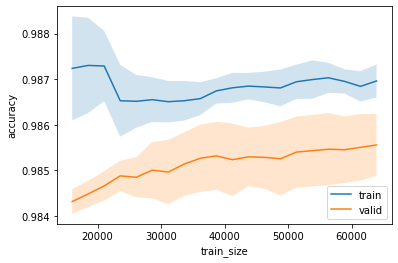

In [70]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

Как видно из графика, увеличение обучающей выборки повышает точность классификации.

Т.к. при увеличении количества пользователей, для которых происводится классификация, точность падает, 
чтобы применять модель в реальных бизнес- задачах, необходимо во первых продолжать работу над самой моделью, создавать новые признаки, которые будут улучшать модель и во вторых, стараться увеличивать количество данных для обучения.

## Часть 5. Соревнование Kaggle "Catch Me If You Can"

Загрузим данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей:

In [71]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [72]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


В обучающей выборке видим следующие признаки: - site1 – индекс первого посещенного сайта в сессии - time1 – время посещения первого сайта в сессии - ... - site10 – индекс 10-го посещенного сайта в сессии - time10 – время посещения 10-го сайта в сессии - user_id – ID пользователя

Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.

Посмотрим на статистику признаков.

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил vk.com в 20:01, потом yandex.ru в 20:29, затем google.com в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта vk.com, time1 – 2015-01-01 20:01:00, site2 – ID сайта yandex.ru, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с google.com пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения vk.com.

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [74]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.

In [75]:
train_test_df = pd.concat([train_df, test_df])

In [76]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [77]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создадим разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее, потом разделим обратно на обучающую и тестовую части.**

**Выделим в отдельный вектор *y* ответы на обучающей выборке.**

In [78]:
train_test_sparse = convert_to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df.target.astype('int').values

**Создадим объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь. Обучим  модель на выборке `(X_train, y_train)`.**

In [79]:
sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

Запишем ответы в файл и сделайте посылку на Kaggle.

In [80]:
write_to_submission_file(sgd_logit.predict_proba(X_test_sparse)[:, 1], 'C6W5_kaggle1.csv') 

Результат на kaggle: 0.91646. Это baseline

Добавим 4 бинарных столбца, единица в которых будет обозначать начало сессии утром\днем\вечером\ночью

In [81]:
times_df_train = train_df[['time%d' % i for i in range(1, 11)]].apply(pd.to_datetime)
times_df_test = test_df[['time%d' % i for i in range(1, 11)]].apply(pd.to_datetime)

In [82]:
hour = times_df_train['time1'].apply(lambda ts: ts.hour)

In [83]:
X_train_new = add_time_features(times_df_train.fillna(0), X_train_sparse)
X_test_new = add_time_features(times_df_test.fillna(0), X_test_sparse)

In [84]:
sgd_logit.fit(X_train_new, y)

SGDClassifier(loss='log', random_state=17)

In [85]:
logit_test_pred_proba2 = sgd_logit.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred_proba2, 'C6W5_kaggle2.csv')

Результат на kaggle: 0.93966, добавление этих признаков улучшило модель.

Аналогично добавим 7 столбцов, где единицы будут обозначать день недели начала сессии.

In [86]:
x_train_day = add_day_feature(times_df_train.fillna(0), X_train_new)
x_test_day = add_day_feature(times_df_test.fillna(0), X_test_new)

(253561, 48375) (253561, 7)
(82797, 48375) (82797, 7)


In [87]:
sgd_logit.fit(x_train_day, y)

SGDClassifier(loss='log', random_state=17)

In [88]:
logit_test_pred_proba3 = sgd_logit.predict_proba(x_test_day)[:, 1]
write_to_submission_file(logit_test_pred_proba3, 'C6W5_kaggle3.csv')

Результат на kaggle: 0.94285. Добавление дня начала сессии еще улучшило результат.
Таким образом, добавлением этих двух признаков мы улучшили точность прогноза на 0.02639

## Часть 6.  Vowpal Wabbit

Попробуем поработать с библиотекой Vowpal Wabbit на примере классификации на 400 пользователей.

In [89]:
train_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions_400users.csv'), 
                           index_col='session_id')
test_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions_400users.csv'), 
                           index_col='session_id')
train_df_400.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


**Видим, что в обучающей выборке 182793 сессий, в тестовой – 46473, и сессии действительно принадлежат 400 различным пользователям.**

In [90]:
train_df_400.shape, test_df_400.shape, train_df_400['user_id'].nunique()

((182793, 21), (46473, 20), 400)

**Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 400). Поэтому придется применить `LabelEncoder`, да еще и +1 потом добавить (`LabelEncoder` переводит метки в диапозон от 0 до K-1). Потом надо будет применить обратное преобразование.**

In [91]:
y = train_df_400.user_id
class_encoder = LabelEncoder()
y_for_vw = class_encoder.fit_transform(train_df_400.user_id) + 1

**Реализуйте функцию, `arrays_to_vw(X, y=None, train=True, out_file='tmp.vw')`, переводящую обучающую выборку в формат Vowpal Wabbit.**

Вход:
 - X – матрица `NumPy` (обучающая выборка)
 - y - вектор ответов (`NumPy`).
 - train – флаг, True в случае обучающей выборки, False – в случае тестовой выборки
 - out_file – путь к файлу .vw, в который будет произведена запись

**Применим написанную функцию ко всей обучающей выборке и ко всей тестовой выборке.

In [92]:
sites = ['site' + str(i) for i in range(1, 11)]
train_df_sites = train_df_400[sites].fillna(0).astype('int')
test_df_sites = test_df_400[sites].fillna(0).astype('int')
arrays_to_vw(train_df_sites.fillna(0).values, y_for_vw, train=True, out_file='train.vw')
arrays_to_vw(test_df_sites.fillna(0).values, train=False, out_file='test.vw')

**Обучим модель VW на всей обучающей выборке – *train.vw*.**

In [93]:
%%time
!vw --oaa 400 train.vw --passes 3 --random_seed 17 -b 26 \
    --cache_file train_.vw_cache -k -f vw_full_model.vw --quiet

Wall time: 34.8 s


**Сделаем прогноз для тестовой выборки.**

In [94]:
!vw -i vw_full_model.vw -t test.vw -p vw_full_valid_pred.csv --quiet

**Запишем прогноз в файл, предварительно применив обратное преобразование меток (был LabelEncoder и потом +1 в меткам) и отправим решение на Kaggle.**

In [95]:
vw_pred = class_encoder.inverse_transform(pd.read_csv('vw_full_valid_pred.csv', header = None).values - 1)
write_to_submission_file(vw_pred, 'vw_400_users.csv')

Полученная точность на тестовой выборке: 0.18768, время обучения - 35с

Для сравнения, обученные на этой же выборке логистическая регрессия обучалась 5 мин 49 сек и показала точность 0.19835.
Для огромных выборок, использоваение VW может быть хорошей идеей.